In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from agent import Agent, Env
from pfilter import ParticleFilter

In [2]:
np.random.seed(10)
random.seed(10)

In [3]:
im_x = 50
im_y = 50

seqlen = 200

In [4]:
env = Env(*[Agent(im_x, im_y) for _ in range(1)])

In [5]:
aa = env.step()[0]

In [6]:
aa

array([ 28.61702713,  30.4745518 ,  36.37981087,  34.75076316])

In [7]:
def evol_model(particles):
    particles = particles.copy()
    
    xy, wh = particles[:,:2], particles[:,2:4]
    vel = particles[:,4:]
    
    vel += np.random.normal(size=vel.shape)/4
    vel = np.clip(vel, -1, 1)
    
    xy += vel
    
    wh += np.random.normal(size=wh.shape)/20
    wh = np.clip(wh, 1, 30)
    
    xy = np.clip(xy, 0, np.array([im_x, im_y], dtype='float64') - wh)
    
    new_particles = np.concatenate([xy, wh, vel], axis=-1)
    return new_particles

def observe_model(particles, observe, beta=None):
    xy, wh = particles[:,:2], particles[:,2:4]
    
    xyxy = np.concatenate([xy, xy + wh], axis=-1)
    
    whs = np.concatenate([wh,wh], axis=-1)
    
    ds = []
    for obs in observe:
        logd = - (xyxy - obs)**2/(2*(whs/12)**2) - np.log(np.sqrt(2*np.pi)*whs/12)
        logd = np.clip(logd, -10000, 10000)
        logd = np.sum(logd, axis=-1)
        ds.append(logd)
    
    
    ds = np.array(ds)

    if beta is not None:
        beta = np.array(beta)
        tmp = logsumexp(ds, b=beta[:,np.newaxis], axis=0)
        if np.max(beta) < 1e-3:
            return 0
        else:
            return tmp
    else:
        return ds[0]

In [8]:
filt = ParticleFilter(20000, 4 + 2, evol_model, observe_model, resample_criterion=0.7)

In [9]:
aa = env.step(see_all=True)[0]
filt.particles[:, :2] = aa[:2] + np.random.normal(size=filt.particles[:, :2].shape)*2
filt.particles[:, 2:4] = np.clip(1 + np.random.normal(size=filt.particles[:, 2:4].shape)*7, 0.5, 100)

In [10]:
observe = []
true = []
for _ in range(seqlen):
    observe.append(env.step())
    true.append(env.agents[0].pos)
    
observe = np.array(observe)
true = np.array(true)

In [11]:
agent = env.agents[0]

In [12]:
agent.w, agent.h

(8, 4)

In [13]:
filtrated = filt.filtrate(observe)

0.000603937867018
0.101322992262
0.0598909718822
0.198050995641
0.08680960311
0.297930391118
0.457111249336
0.128698232213
0.179024989458
0.408093955519
0.155660893651
0.255127045045
0.133821324125
0.12984405777
0.12229766866
0.44951808117
0.475827682047
0.956399105374
0.00115086897068
0.0113193478594
0.555325928257
0.87583096849
0.414429878487
0.015822865094
0.00247186449333
0.0456850658807
0.232450539267
0.297331829946
0.277963740522
0.356554193371
0.30898480844
0.319128637264
0.236014907942
0.07585110789
0.158895128118
0.0905195047665
0.190181786711
0.0301776552451
0.0990298866605
0.0492206033578
0.0204032824973
0.0170557613114
0.00489915645414
0.00934659204746
0.00515409386179
0.00652800201127
0.00305373434918
0.000157668913176
0.0118202318774
0.00482885252639
0.00393125236432
0.047996893137
0.0371241044873
0.0263728678806
0.0354179291724
0.0571705463835
0.0433792696929
0.0192153738219
0.0249028195539
0.0889525533271
0.133818372956
0.199534054284
0.324400714323
0.440165805514
0.284

In [14]:
filtrated.shape

(200, 20000, 6)

In [15]:
fmean = filtrated.mean(axis=1)

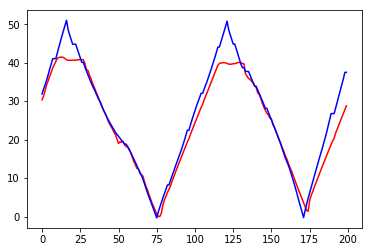

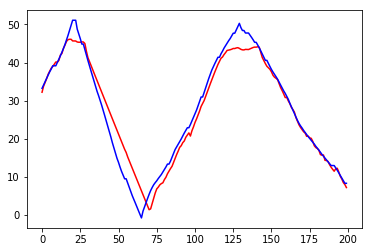

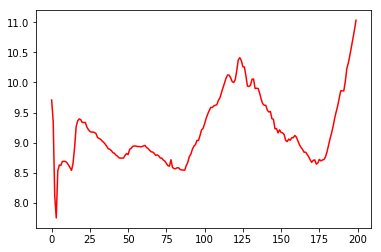

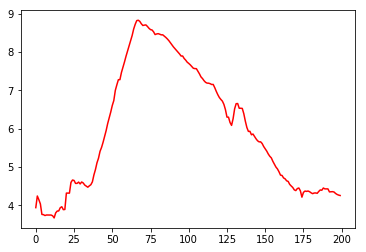

In [16]:
plt.plot(range(seqlen), fmean[:,0], c='r')
plt.plot(range(seqlen), true[:,0], c='b')
plt.show()

plt.plot(range(seqlen), fmean[:,1], c='r')
plt.plot(range(seqlen), true[:,1], c='b')
plt.show()

plt.plot(range(seqlen), fmean[:,2], c='r')
plt.show()

plt.plot(range(seqlen), fmean[:,3], c='r')
plt.show()